In [1]:
#TO DO - PLAY AROUND WITH SMT PARAMETERS UNTIL YOU GET SENSIBLE FA/MD! CAN MATCH SMT MAX/MIN TO HCP DATA FIT

#write simulation funct#[noiseless, directional] signal and model and ROImask [dti], set random seedion that outputs ground truth 



#TO DO CALCULATE BIAS AND VARIANCE


#Paddy to do: 1. test-restest simulations; 2. "lesion" simulation
#Paddy. 3. rois based on clustering from lsq fit - can do kmeans etc, might need a bit of tuning but should be ok







In [2]:
#load modules

import numpy as np
import matplotlib.pyplot as plt


In [3]:
#set the random seed so that you get the same simulations
np.random.seed(seed=1)

In [4]:
from dmipy.signal_models import cylinder_models, gaussian_models
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()



/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from dmipy.distributions.distribute_models import BundleModel
bundle = BundleModel([stick, zeppelin])
bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0')
bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
bundle.set_equal_parameter('G2Zeppelin_1_mu', 'C1Stick_1_mu')



In [6]:
#set up two models - directional and direction averaged

from dmipy.core import modeling_framework
mc_smt_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[bundle])
mc_smt_mod.parameter_names


mc_mod = modeling_framework.MultiCompartmentModel(
    models=[bundle])
mc_mod.parameter_names



We highly recommend installing pathos to take advantage of multicore processing.
We highly recommend installing pathos to take advantage of multicore processing.


['BundleModel_1_G2Zeppelin_1_mu',
 'BundleModel_1_partial_volume_0',
 'BundleModel_1_G2Zeppelin_1_lambda_par']

In [7]:
#set up the ground truth parameter values in each ROI



#number of voxels for each tissue type
#n_wm = 40000
#n_gm = 20000
#n_csf = 10000 
n_wm = 500
n_gm = 300
n_csf = 100

#WM = 1, GM = 2, CSF =3
ROImask_gt = np.concatenate((np.ones((n_wm,)),2*np.ones((n_gm,)),3*np.ones((n_csf,))))                      

#choose some parameters for the simulated SMT-NODDI model 
lambda_par_wm = [1.5e-9, 2.5e-9]
lambda_par_gm = [0.5e-9, 1.5e-9]
lambda_par_csf = [2.9e-9, 3e-9]
mu_1 = [0, np.pi]
mu_2 = [-np.pi,np.pi]
f_stick_wm = [0.6, 0.8]
f_stick_gm = [0.2, 0.4]
f_stick_csf = [0, 0.01]


# lambda_par = np.concatenate((np.random.uniform(low=lambda_par_wm[0],high=lambda_par_wm[1], size = n_wm),
#                       np.random.uniform(low=lambda_par_gm[0],high=lambda_par_gm[1], size = n_gm),
#                       np.random.uniform(low=lambda_par_csf[0],high=lambda_par_csf[1], size = n_csf)))
              
# f_stick = np.concatenate((np.random.uniform(low=f_stick_wm[0],high=f_stick_wm[1], size = n_wm),
#                       np.random.uniform(low=f_stick_gm[0],high=f_stick_gm[1], size = n_gm),
#                       np.random.uniform(low=f_stick_csf[0],high=f_stick_csf[1], size = n_csf)))

lambda_par = np.concatenate((np.random.normal(loc=np.mean(lambda_par_wm),scale=.1e-9, size = n_wm),
                      np.random.normal(loc=np.mean(lambda_par_gm),scale=.1e-9, size = n_gm),
                      np.random.normal(loc=np.mean(lambda_par_csf),scale=.1e-9, size = n_csf)))
              
f_stick = np.concatenate((np.random.normal(loc=np.mean(f_stick_wm),scale=0.05, size = n_wm),
                      np.random.normal(loc=np.mean(f_stick_gm),scale=0.05, size = n_gm),
                      np.random.normal(loc=np.mean(f_stick_csf),scale=0.001, size = n_csf)))


mu_1 = np.random.uniform(low=mu_1[0],high=mu_1[1],size=n_wm+n_gm+n_csf)
mu_2 = np.random.uniform(low=mu_2[0],high=mu_2[1],size=n_wm+n_gm+n_csf)

mu = np.stack((mu_1,mu_2),axis=1)

f_free = 1 - f_stick



# stick_par = np.concatenate((np.random.uniform(low=stick_par_wm[0],high=stick_par_wm[1], size = n_wm),
#                       np.random.uniform(low=stick_par_gm[0],high=stick_par_gm[1], size = n_gm),
#                       np.random.uniform(low=stick_par_csf[0],high=stick_par_csf[1], size = n_csf)))




#put into a big parameter vector that can be passed into simulate_signal
parameters_vector = mc_mod.parameters_to_parameter_vector(BundleModel_1_G2Zeppelin_1_mu=mu,
                                                                BundleModel_1_G2Zeppelin_1_lambda_par=lambda_par,
                                                                BundleModel_1_partial_volume_0=f_stick)
                                                        








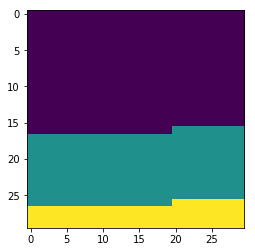

In [78]:
plt.imshow(np.reshape(ROImask_gt,(30,30)))


In [8]:
#get the saved hcp scheme
from dmipy.data import saved_acquisition_schemes

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [13]:
#simulate the signal using the DIRECTIONAL model 

raw_signals = mc_mod.simulate_signal(acq_scheme,parameters_vector)

from useful_functions import add_noise

signals = add_noise(raw_signals,snr=25)

#also do a "retest" simulation - same underlying parameters but different noise
signals_retest = add_noise(raw_signals,snr=25)


In [10]:
#calculate the ROImask using a diffusion tensor fit in dipy

#set up the dipy aquisition
from dipy.core.gradients import gradient_table
gtab = gradient_table(acq_scheme.bvalues, acq_scheme.gradient_directions)

#
import dipy.reconst.dti as dti

tenmodel = dti.TensorModel(gtab)

tenfit = tenmodel.fit(signals)



In [11]:
#threshold md and fa to estimate the ROImask
md_thresh = 1e-9
fa_thresh = 0.8

ROImask = np.zeros_like(ROImask_gt)

#white matter - less than md threshold and higher than fa threshold
ROImask[(tenfit.md < md_thresh) & (tenfit.fa > fa_thresh)] = 1
#grey matter - less than md threshold and less than fa threshold
ROImask[(tenfit.md < md_thresh) & (tenfit.fa < fa_thresh)] = 2
#csf - higher than md threshold and lower than fa threshold
ROImask[(tenfit.md > md_thresh) & (tenfit.fa < fa_thresh)] = 3




In [14]:
#fit the MC spherical mean model (CHECK AGAINST DIRECTION AVERAGING FIRST!)
mc_smt_mod_lsq_fit = mc_smt_mod.fit(acq_scheme, signals)

mc_smt_mod_lsq_fit_retest = mc_smt_mod.fit(acq_scheme, signals_retest)


Setup brute2fine optimizer in 0.004864215850830078 seconds
Fitting of 900 voxels complete in 4.815649032592773 seconds.
Average of 0.005350721147325304 seconds per voxel.
Setup brute2fine optimizer in 0.0037419795989990234 seconds
Fitting of 900 voxels complete in 5.995206117630005 seconds.
Average of 0.0066613401307000055 seconds per voxel.


In [17]:
def estimate_ROIs_kmeans(parameters_vector,n_clusters):
    #cluster the voxels into ROIs using kmeans - could do this iteratively?
    from sklearn.cluster import KMeans
    import numpy as np
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(parameters_vector)

    ROImask = kmeans.labels_ + 1
    
    return ROImask


n_clusters=3

#do it for the test
ROImask = estimate_ROIs_kmeans(mc_smt_mod_lsq_fit.fitted_parameters_vector, n_clusters)
#do it for the retest
ROImask_retest = estimate_ROIs_kmeans(mc_smt_mod_lsq_fit_retest.fitted_parameters_vector, n_clusters)





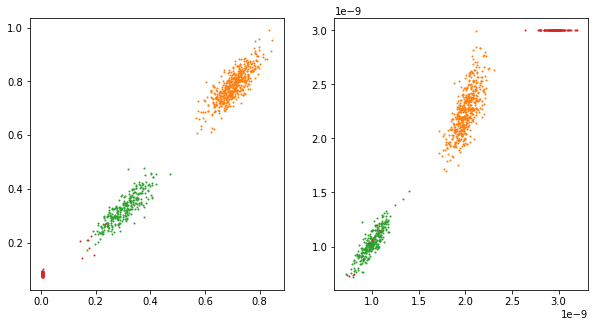

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])

for roi in range(0,int(np.max(ROImask))+1):
    axs[0].plot(f_stick[ROImask==roi],mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask==roi],'o',markersize=1)
        
    axs[1].plot(lambda_par[ROImask==roi],mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],'o',markersize=1)    

    #calculate MSE
    
    
#axs[0].set_xlim([0,1])
#axs[0].set_ylim([0,1])

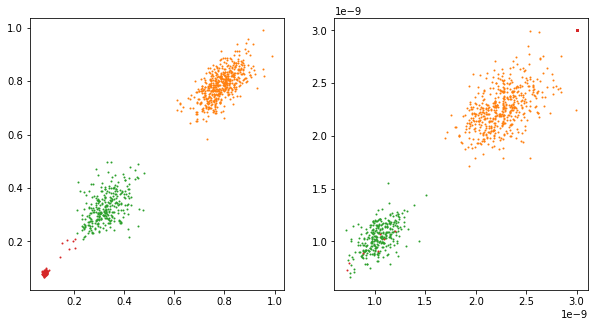

In [18]:
#test-retest plot 
fig, axs = plt.subplots(1, 2, figsize=[10, 5])

for roi in range(0,int(np.max(ROImask))+1):
    axs[0].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask==roi],
                mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_retest==roi],'o',markersize=1)
        
    axs[1].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],
                mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_retest==roi],'o',markersize=1)    

    
    

In [21]:
from useful_functions import create_spherical_mean_scheme
from dmipy.utils import spherical_mean

acq_scheme_smt = create_spherical_mean_scheme(acq_scheme)

#signals_sm = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals, acq_scheme) ] 
signals_sm = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals[i,:], acq_scheme) for i in range(0,n_wm+n_gm+n_csf)])

signals_sm_retest = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals_retest[i,:], acq_scheme) for i in range(0,n_wm+n_gm+n_csf)])





In [22]:
E_fit = mc_smt_mod.simulate_signal(acq_scheme_smt,mc_smt_mod_lsq_fit.fitted_parameters_vector)

E_fit_retest = mc_smt_mod.simulate_signal(acq_scheme_smt,mc_smt_mod_lsq_fit_retest.fitted_parameters_vector)


In [23]:
import time 
import fit_bayes_new


nsteps=1000
burn_in=500
nupdates=20

# hierarchical Bayesian fitting
#proc_start = time.time()
parameters_bayes_dict, acceptance_rate, parameter_convergence, likelihood, weights\
    = fit_bayes_new.fit(mc_smt_mod, acq_scheme_smt, signals_sm, E_fit, mc_smt_mod_lsq_fit.fitted_parameters, ROImask, nsteps, burn_in, nupdates)
#compute_time(proc_start, time.time())

#retest
parameters_bayes_dict_retest, acceptance_rate_retest, parameter_convergence_retest, likelihood_retest, weights_retest\
    = fit_bayes_new.fit(mc_smt_mod, acq_scheme_smt, signals_sm_retest, E_fit_retest, mc_smt_mod_lsq_fit_retest.fitted_parameters, ROImask_retest, nsteps, burn_in, nupdates)




 >> at start of fit_bayes.fit
 >> extracting ROIs
 >> setting up dictionary
BundleModel_1_partial_volume_0
BundleModel_1_G2Zeppelin_1_lambda_par
 >> setting up weights
 >> initialising dictionaries
26
26
 >> starting loop
ROI 1/3; 500 voxels
mcmc step = 0/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 1/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 2/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 3/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 4/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 5/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 6/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 7/1000
param = Bun

mcmc step = 76/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 77/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 78/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 79/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 80/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 81/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 82/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 83/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 84/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 85/1000
param = BundleModel_1_partial_volum

mcmc step = 154/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 155/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 156/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 157/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 158/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 159/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 160/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 161/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 162/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 163/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 233/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 234/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 235/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 236/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 237/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 238/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 239/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 240/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 241/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 310/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 311/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 312/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 313/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 314/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 315/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 316/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 317/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 318/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 319/1000
param = BundleModel_1_par

mcmc step = 388/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 389/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 390/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 391/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 392/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 393/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 394/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 395/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 396/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 397/1000
param = BundleModel_1_par

mcmc step = 466/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 467/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 468/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 469/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 470/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 471/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 472/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 473/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 474/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 475/1000
param = BundleModel_1_par

mcmc step = 544/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 545/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 546/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 547/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 548/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 549/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 550/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 551/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 552/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 553/1000
param = BundleModel_1_par

mcmc step = 622/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 623/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 624/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 625/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 626/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 627/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 628/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 629/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 630/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 631/1000
param = BundleModel_1_par

mcmc step = 700/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 701/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 702/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 703/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 704/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 705/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 706/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 707/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 708/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 709/1000
param = BundleModel_1_par

mcmc step = 778/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 779/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 780/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 781/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 782/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 783/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 784/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 785/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 786/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 787/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 857/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 858/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 859/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 860/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 861/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 862/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 863/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 864/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 865/1000
param = BundleModel_1_partial_volume_0
param =

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 935/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 936/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 937/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 938/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 939/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 940/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 941/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 942/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 943/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 12/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 13/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 14/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 15/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 16/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 17/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 18/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 19/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 20/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 21/1000
param = BundleModel_1_partial_volum

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 91/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 92/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 93/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 94/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 95/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 96/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 97/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 98/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 99/1000
param = BundleModel_1_partial_volume_0
param = BundleMo

mcmc step = 168/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 169/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 170/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 171/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 172/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 173/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 174/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 175/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 176/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 177/1000
param = BundleModel_1_par

mcmc step = 246/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 247/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 248/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 249/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 250/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 251/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 252/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 253/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 254/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 255/1000
param = BundleModel_1_par

mcmc step = 324/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 325/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 326/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 327/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 328/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 329/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 330/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 331/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 332/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 333/1000
param = BundleModel_1_par

mcmc step = 402/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 403/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 404/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 405/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 406/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 407/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 408/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 409/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 410/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 411/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 481/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 482/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 483/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 484/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 485/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 486/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 487/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 488/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 489/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 558/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 559/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 560/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 561/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 562/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 563/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 564/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 565/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 566/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 567/1000
param = BundleModel_1_par

mcmc step = 636/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 637/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 638/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 639/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 640/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 641/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 642/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 643/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 644/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 645/1000
param = BundleModel_1_par

mcmc step = 714/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 715/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 716/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 717/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 718/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 719/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 720/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 721/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 722/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 723/1000
param = BundleModel_1_par

mcmc step = 792/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 793/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 794/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 795/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 796/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 797/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 798/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 799/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 800/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 801/1000
param = BundleModel_1_par

mcmc step = 870/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 871/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 872/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 873/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 874/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 875/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 876/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 877/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 878/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 879/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 949/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 950/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 951/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 952/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 953/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 954/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 955/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 956/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 957/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 26/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 27/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 28/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 29/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 30/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 31/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 32/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 33/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 34/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 35/1000
param = BundleModel_1_partial_volum

param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 104/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 105/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 106/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 107/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 108/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 109/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 110/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 111/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 112/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par


mcmc step = 181/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 182/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 183/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 184/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 185/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 186/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 187/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 188/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 189/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 190/1000
param = BundleModel_1_par

mcmc step = 259/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 260/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 261/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 262/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 263/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 264/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 265/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 266/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 267/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 268/1000
param = BundleModel_1_par

mcmc step = 337/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 338/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 339/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 340/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 341/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 342/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 343/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 344/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 345/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 346/1000
param = BundleModel_1_par

mcmc step = 415/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 416/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 417/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 418/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 419/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 420/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 421/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 422/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 423/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 424/1000
param = BundleModel_1_par

mcmc step = 493/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 494/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 495/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 496/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 497/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 498/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 499/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 500/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 501/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 502/1000
param = BundleModel_1_par

mcmc step = 571/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 572/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 573/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 574/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 575/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 576/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 577/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 578/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 579/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 580/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 650/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 651/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 652/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 653/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 654/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 655/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 656/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 657/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 658/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 727/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 728/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 729/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 730/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 731/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 732/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 733/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 734/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 735/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 736/1000
param = BundleModel_1_par

mcmc step = 805/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 806/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 807/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 808/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 809/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 810/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 811/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 812/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 813/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 814/1000
param = BundleModel_1_par

mcmc step = 883/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 884/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 885/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 886/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 887/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 888/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 889/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 890/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 891/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 892/1000
param = BundleModel_1_par

mcmc step = 961/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 962/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 963/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 964/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 965/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 966/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 967/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 968/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 969/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 970/1000
param = BundleModel_1_par

mcmc step = 37/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 38/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 39/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 40/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 41/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 42/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 43/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 44/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 45/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 46/1000
param = BundleModel_1_partial_volum

mcmc step = 115/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 116/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 117/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 118/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 119/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 120/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 121/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 122/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 123/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 124/1000
param = BundleModel_1_par

mcmc step = 193/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 194/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 195/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 196/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 197/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 198/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 199/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 200/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 201/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 202/1000
param = BundleModel_1_par

mcmc step = 271/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 272/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 273/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 274/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 275/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 276/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 277/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 278/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 279/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 280/1000
param = BundleModel_1_par

mcmc step = 349/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 350/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 351/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 352/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 353/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 354/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 355/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 356/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 357/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 358/1000
param = BundleModel_1_par

mcmc step = 427/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 428/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 429/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 430/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 431/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 432/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 433/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 434/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 435/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 436/1000
param = BundleModel_1_par

mcmc step = 505/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 506/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 507/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 508/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 509/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 510/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 511/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 512/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 513/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 514/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 584/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 585/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 586/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 587/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 588/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 589/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 590/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 591/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 592/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 661/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 662/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 663/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 664/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 665/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 666/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 667/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 668/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 669/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 670/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 740/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 741/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 742/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 743/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 744/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 745/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 746/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 747/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 748/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 817/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 818/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 819/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 820/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 821/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 822/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 823/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 824/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 825/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 826/1000
param = BundleModel_1_par

mcmc step = 895/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 896/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 897/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 898/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 899/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 900/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 901/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 902/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 903/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 904/1000
param = BundleModel_1_par

mcmc step = 973/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 974/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 975/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 976/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 977/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 978/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 979/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 980/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 981/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 982/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 52/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 53/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 54/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 55/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 56/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 57/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 58/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 59/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 60/1000
param = BundleModel_1_partial_volume_0
param = BundleMo

mcmc step = 129/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 130/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 131/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 132/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 133/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 134/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 135/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 136/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 137/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 138/1000
param = BundleModel_1_par

mcmc step = 207/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 208/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 209/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 210/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 211/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 212/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 213/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 214/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 215/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 216/1000
param = BundleModel_1_par

mcmc step = 285/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 286/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 287/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 288/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 289/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 290/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 291/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 292/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 293/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 294/1000
param = BundleModel_1_par

mcmc step = 363/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 364/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 365/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 366/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 367/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 368/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 369/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 370/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 371/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 372/1000
param = BundleModel_1_par

mcmc step = 441/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 442/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 443/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 444/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 445/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 446/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 447/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 448/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 449/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 450/1000
param = BundleModel_1_par

mcmc step = 519/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 520/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 521/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 522/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 523/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 524/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 525/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 526/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 527/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 528/1000
param = BundleModel_1_par

mcmc step = 597/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 598/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 599/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 600/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 601/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 602/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 603/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 604/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 605/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 606/1000
param = BundleModel_1_par

mcmc step = 675/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 676/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 677/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 678/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 679/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 680/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 681/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 682/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 683/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 684/1000
param = BundleModel_1_par

mcmc step = 753/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 754/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 755/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 756/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 757/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 758/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 759/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 760/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 761/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 762/1000
param = BundleModel_1_par

mcmc step = 831/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 832/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 833/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 834/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 835/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 836/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 837/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 838/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 839/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 840/1000
param = BundleModel_1_par

mcmc step = 909/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 910/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 911/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 912/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 913/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 914/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 915/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 916/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 917/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 918/1000
param = BundleModel_1_par

mcmc step = 987/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 988/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 989/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 990/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 991/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 992/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 993/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 994/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 995/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 996/1000
param = BundleModel_1_par

mcmc step = 65/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 66/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 67/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 68/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 69/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 70/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 71/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 72/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 73/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 74/1000
param = BundleModel_1_partial_volum

mcmc step = 143/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 144/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 145/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 146/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 147/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 148/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 149/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 150/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 151/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 152/1000
param = BundleModel_1_par

mcmc step = 221/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 222/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 223/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 224/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 225/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 226/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 227/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 228/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 229/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 230/1000
param = BundleModel_1_par

mcmc step = 299/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 300/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 301/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 302/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 303/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 304/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 305/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 306/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 307/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 308/1000
param = BundleModel_1_par

mcmc step = 377/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 378/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 379/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 380/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 381/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 382/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 383/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 384/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 385/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 386/1000
param = BundleModel_1_par

mcmc step = 455/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 456/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 457/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 458/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 459/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 460/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 461/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 462/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 463/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 464/1000
param = BundleModel_1_par

mcmc step = 533/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 534/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 535/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 536/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 537/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 538/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 539/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 540/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 541/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 542/1000
param = BundleModel_1_par

mcmc step = 611/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 612/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 613/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 614/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 615/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 616/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 617/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 618/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 619/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 620/1000
param = BundleModel_1_par

mcmc step = 689/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 690/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 691/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 692/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 693/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 694/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 695/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 696/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 697/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 698/1000
param = BundleModel_1_par

mcmc step = 767/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 768/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 769/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 770/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 771/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 772/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 773/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 774/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 775/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 776/1000
param = BundleModel_1_par

param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 846/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 847/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 848/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 849/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 850/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 851/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 852/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 853/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 854/1000
param = BundleModel_1_partial_volume_0
param =

mcmc step = 923/1000


/Users/paddyslator/dmipy-bayesian/fit_bayes_new.py:291: RuntimeWarning: divide by zero encountered in log
  prior_new = prior_new + np.log(scipy.stats.multivariate_normal.pdf(parameter_vector, mu, sigma, allow_singular=1))


param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 924/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 925/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 926/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 927/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 928/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 929/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 930/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 931/1000
param = BundleModel_1_partial_volume_0
param = BundleModel_1_G2Zeppelin_1_lambda_par
mcmc step = 932/1000
param = BundleModel_1_partial_volume_0
param =

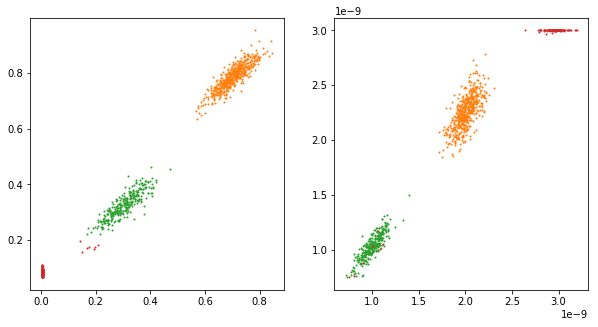

In [25]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])

for roi in range(0,int(np.max(ROImask))+1):
    axs[0].plot(f_stick[ROImask==roi],parameters_bayes_dict['BundleModel_1_partial_volume_0'][ROImask==roi],'o',markersize=1)
        
    axs[1].plot(lambda_par[ROImask==roi],parameters_bayes_dict['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],'o',markersize=1)    
    
#    MSE['BundleModel_1_partial_volume_0'][roi] = 
#    MSE['BundleModel_1_G2Zeppelin_1_lambda_par'][roi] = 

#axs[0].set_xlim([0,1])
#axs[0].set_ylim([0,1])

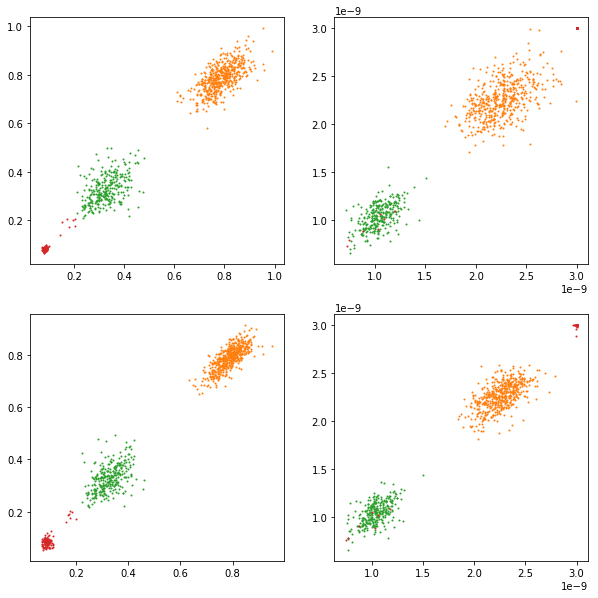

In [32]:
#test-retest plots - plot lsq on the same plot
fig, axs = plt.subplots(2, 2, figsize=[10, 10])

for roi in range(0,int(np.max(ROImask))+1):
    
    #Least squares
    axs[0,0].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask==roi],
                mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_retest==roi],'o',markersize=1)
        
    axs[0,1].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],
                mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_retest==roi],'o',markersize=1)    

    
    #Bayesian
    axs[1,0].plot(parameters_bayes_dict['BundleModel_1_partial_volume_0'][ROImask==roi],
                parameters_bayes_dict_retest['BundleModel_1_partial_volume_0'][ROImask_retest==roi],
                'o',markersize=1)
        
    axs[1,1].plot(parameters_bayes_dict['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask==roi],
                parameters_bayes_dict_retest['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_retest==roi],
                'o',markersize=1)    

    
 




In [34]:
import matplotlib.pyplot as plt
import numpy as np    
    
def bland_altman_plot(data1, data2, *args, **kwargs):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2                   # Difference between data1 and data2
    md      = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    
    

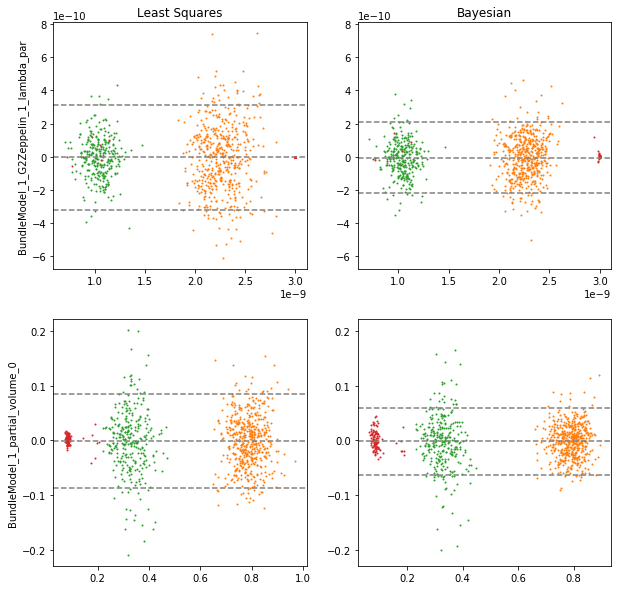

In [57]:
#Bland-Altman plots

#test-retest plots 
fig, axs = plt.subplots(2, 2, figsize=[10, 10])

for roi in range(0,int(np.max(ROImask))+1):
    for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    
        #Least squares
        mean = np.mean([mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==roi],
                    mc_smt_mod_lsq_fit_retest.fitted_parameters[param][ROImask_retest==roi]],axis=0)

        diff = mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==roi] - \
                    mc_smt_mod_lsq_fit_retest.fitted_parameters[param][ROImask_retest==roi]
        
        axs[i,0].plot(mean, diff, 'o', markersize=1)
                
#         #plot mean of the difference for each ROI separately 
#         axs[i,0].axhline(np.mean(diff), color='gray', linestyle='--')
#         axs[i,0].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
#         axs[i,0].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
        

        #Bayesian
        mean = np.mean([parameters_bayes_dict[param][ROImask==roi],
                    parameters_bayes_dict_retest[param][ROImask_retest==roi]],axis=0)

        diff = parameters_bayes_dict[param][ROImask==roi] - \
                    parameters_bayes_dict_retest[param][ROImask_retest==roi]
                    
        axs[i,1].plot(mean, diff, 'o', markersize=1)
        
        #for easy comparison, make the bayesian y-axis limits the same as the LSQ        
        axs[i,1].set_ylim(axs[i,0].get_ylim())

        
#         #plot mean of the difference for each ROI separately 
#         axs[i,1].axhline(np.mean(diff), color='gray', linestyle='--')
#         axs[i,1].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
#         axs[i,1].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')


#add labels
axs[0,0].set_title('Least Squares')
axs[0,1].set_title('Bayesian')

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    axs[i,0].set_ylabel(param)
    axs[i,0].set_ylabel(param)
    


#plot mean and sd of the difference for all voxels together 

#LSQ
# mean = np.mean([mc_smt_mod_lsq_fit.fitted_parameters[param],
#             mc_smt_mod_lsq_fit_retest.fitted_parameters[param]],axis=0)

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    diff = mc_smt_mod_lsq_fit.fitted_parameters[param] - \
                mc_smt_mod_lsq_fit_retest.fitted_parameters[param]

    axs[i,0].axhline(np.mean(diff), color='gray', linestyle='--')
    axs[i,0].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
    axs[i,0].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')

    #Bayesian
    diff = parameters_bayes_dict[param] - \
                parameters_bayes_dict_retest[param]        
    axs[i,1].axhline(np.mean(diff), color='gray', linestyle='--')
    axs[i,1].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
    axs[i,1].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')



# #create Bland-Altman plot                  
# f, ax = plt.subplots(1, figsize = (8,5))
# sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

# #display Bland-Altman plot
# plt.show()


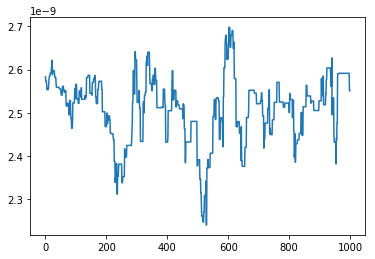

In [26]:
plt.plot(parameter_convergence['BundleModel_1_G2Zeppelin_1_lambda_par'][300,:])

In [100]:
#calculate the contrast to noise ratios, remember WM = 1, GM = 2, CSF =3

def calculate_CNR(ROI1,ROI2):
    mean_ROI1 = np.mean(ROI1)
    mean_ROI2 = np.mean(ROI2)
    
    var_ROI1 = np.var(ROI1)
    var_ROI2 = np.var(ROI2)
    
    CNR = np.abs(mean_ROI1 - mean_ROI2)/np.sqrt(var_ROI1 + var_ROI2)
    
    return CNR

CNR_LSQ={}
CNR_Bayes={}
    
for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    #LSQ
    
#     mean_WM = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1])
#     mean_GM = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])
#     mean_CSF = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
    
#     sd_WM = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1])
#     sd_GM = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])
#     sd_CSF = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
    

    CNR_LSQ[param] = np.zeros(len(mc_smt_mod_lsq_fit.fitted_parameters)+1)
    CNR_Bayes[param] = np.zeros(len(mc_smt_mod_lsq_fit.fitted_parameters)+1)

    
    #between white and grey matter 
    CNR_LSQ[param][0] = calculate_CNR(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1],\
                                     mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])

    #between white matter and CSF
    CNR_LSQ[param][1] = calculate_CNR(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1],\
                                     mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
 
    #between grey matter and CSF
    CNR_LSQ[param][2] = calculate_CNR(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2],\
                                     mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
 

    #Bayesian
    
    #between white and grey matter 
    CNR_Bayes[param][0] = calculate_CNR(parameters_bayes_dict[param][ROImask==1],
                                     parameters_bayes_dict[param][ROImask==2])

    #between white matter and CSF
    CNR_Bayes[param][1] = calculate_CNR(parameters_bayes_dict[param][ROImask==1],
                                     parameters_bayes_dict[param][ROImask==3])
 
    #between grey matter and CSF
    CNR_Bayes[param][2] = calculate_CNR(parameters_bayes_dict[param][ROImask==2],
                                     parameters_bayes_dict[param][ROImask==3])

    
    

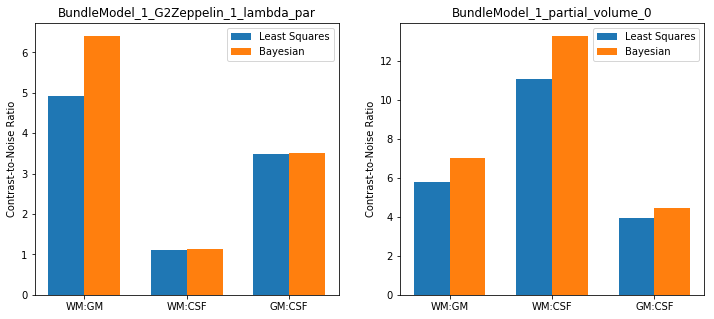

In [162]:
fig, axs = plt.subplots(1, 2, figsize=[12, 5])

bar_width = 0.35

nbars = 3

LSQ_bars = np.arange(3)
Bayes_bars = [x + bar_width for x in LSQ_bars]

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    axs[i].bar(LSQ_bars,CNR_LSQ[param],width=bar_width, label='Least Squares')
    axs[i].bar(Bayes_bars,CNR_Bayes[param],width=bar_width, label='Bayesian')

    axs[i].legend()

    axs[i].set_ylabel('Contrast-to-Noise Ratio')

    #axs[i].set_xticklabels('')
    axs[i].set_xticks([r + bar_width/2 for r in range(nbars)])
    axs[i].set_xticklabels(['WM:GM','WM:CSF','GM:CSF'])
    
    axs[i].set_title(param)

#['WM:GM','WM:CSF','GM:CSF']

#plt.bar(np.arange(3),data)

In [156]:
[r + bar_width/2 for r in range(nbars)]

[0.2, 1.2, 2.2]

In [95]:
mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par']

array([2.50934214e-09, 2.24326007e-09, 2.25034520e-09, 2.07317267e-09,
       2.27099896e-09, 1.71555309e-09, 2.61941074e-09, 2.22100862e-09,
       2.11081366e-09, 1.94728639e-09, 2.24356886e-09, 1.99681758e-09,
       2.27800824e-09, 2.27348674e-09, 2.14116380e-09, 1.96875756e-09,
       2.32539087e-09, 2.20879564e-09, 2.46504226e-09, 2.35501567e-09,
       1.94006367e-09, 2.36575175e-09, 2.52814560e-09, 2.26375125e-09,
       2.40579833e-09, 1.89254875e-09, 2.05047003e-09, 2.27041443e-09,
       2.04534223e-09, 2.07777250e-09, 2.28512060e-09, 2.39776290e-09,
       2.27017242e-09, 1.98929293e-09, 2.14718562e-09, 2.55787773e-09,
       1.95478756e-09, 1.94645980e-09, 2.57091448e-09, 2.28050146e-09,
       2.18631856e-09, 2.22681364e-09, 2.14299067e-09, 2.53144125e-09,
       2.40461819e-09, 2.30778104e-09, 2.37080398e-09, 2.79723529e-09,
       2.04349039e-09, 2.49982629e-09, 2.49084262e-09, 2.18861482e-09,
       2.04885413e-09, 2.16749811e-09, 2.38743940e-09, 2.36226473e-09,
      

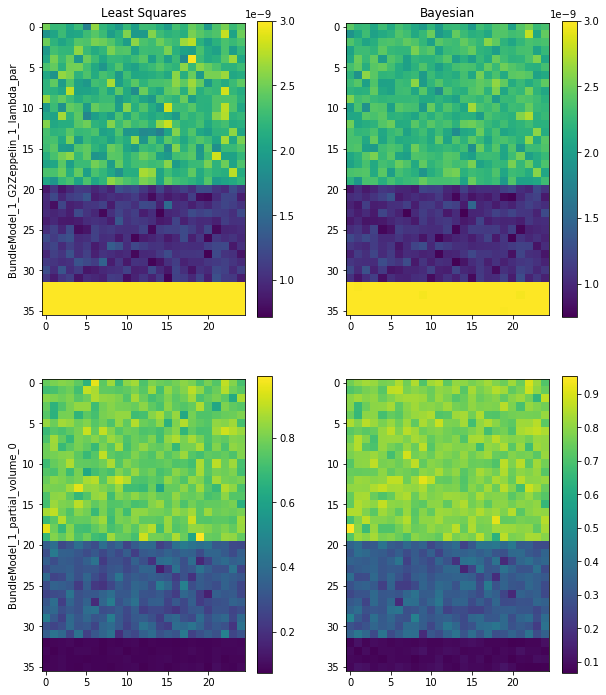

In [171]:
#make the ground truth parameters into an image - can just do this last!
np.sum(ROImask_gt==1)

np.sqrt(300)

fig, axs = plt.subplots(2, 2, figsize=[10, 12])

image_shape = (36,25)

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
#    axs[0,1].imshow(np.reshape(ROImask_gt,image_shape))

    #LSQ
    im=axs[i,0].imshow(np.reshape(mc_smt_mod_lsq_fit.fitted_parameters[param],image_shape))
    fig.colorbar(im,ax=axs[i,0])

    #Bayesian
    im=axs[i,1].imshow(np.reshape(parameters_bayes_dict[param],image_shape))
    fig.colorbar(im,ax=axs[i,1])


    
    
#add labels
axs[0,0].set_title('Least Squares')
axs[0,1].set_title('Bayesian')

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    axs[i,0].set_ylabel(param)
    axs[i,0].set_ylabel(param)
    

In [ ]:
#TO DO CALCULATE BIAS AND VARIANCE


#Paddy to do: 1. test-restest simulations; 2. "lesion" simulation
#Paddy. 3. rois based on clustering from lsq fit - can do kmeans etc, might need a bit of tuning but should be ok

